## **Import libraries**

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, \
                                    Conv2D, \
                                    AveragePooling2D, \
                                    Activation, \
                                    Input, \
                                    Flatten
                                    
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

## **Download the dataset**

Download the datasets from the below links.

https://drive.google.com/file/d/1-16czyoJl7r_Z09NuJ06wPaPkVCsffk7/view?usp=sharing

https://drive.google.com/file/d/1-H6FuinqOeGFVCEvoJAGSMw7V_wa3Lhf/view?usp=sharing

First link is without preprocessing, but the second link has been preprocessed.

Use the below link to know how to work with the data. The file "datasets_preparing.py" in the link can help you alot!

https://www.kaggle.com/valentynsichkar/traffic-signs-preprocessed


In [ ]:
# download traffic_sign data
!gdown --id 1-16czyoJl7r_Z09NuJ06wPaPkVCsffk7
!gdown --id 1-H6FuinqOeGFVCEvoJAGSMw7V_wa3Lhf

Downloading...
From: https://drive.google.com/uc?id=1-16czyoJl7r_Z09NuJ06wPaPkVCsffk7
To: /content/data0.pickle
100% 477M/477M [00:10<00:00, 44.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-H6FuinqOeGFVCEvoJAGSMw7V_wa3Lhf
To: /content/data3.pickle
100% 1.28G/1.28G [00:19<00:00, 67.2MB/s]


In [ ]:
with open('data0.pickle', 'rb') as f:
    data0 = pickle.load(f, encoding='latin1')  # dictionary type


x_train_org = data0['x_train'].transpose(0, 2, 3, 1)
y_train_org = data0['y_train']
x_test_org = data0['x_validation'].transpose(0, 2, 3, 1)
y_test_org = data0['y_validation']

In [ ]:
with open('data3.pickle', 'rb') as f:
    data3 = pickle.load(f, encoding='latin1')  # dictionary type


x_train = data3['x_train'].transpose(0, 2, 3, 1)
y_train = data3['y_train']
x_test = data3['x_validation'].transpose(0, 2, 3, 1)
y_test = data3['y_validation']

In [ ]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (86989, 32, 32, 3)
y_train shape: (86989,)
x_test shape: (4410, 32, 32, 3)
y_test shape: (4410,)


In [ ]:
input_shape = x_train[0].shape
print(input_shape)

(32, 32, 3)


In [ ]:
num_classes = np.unique(y_train).shape[0] # 43
print(num_classes)

43


In [ ]:
# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (86989, 43)
y_test shape: (4410, 43)


## **Display the dataset**

Plot some samples from the first dataset to see and know what are you working with. 

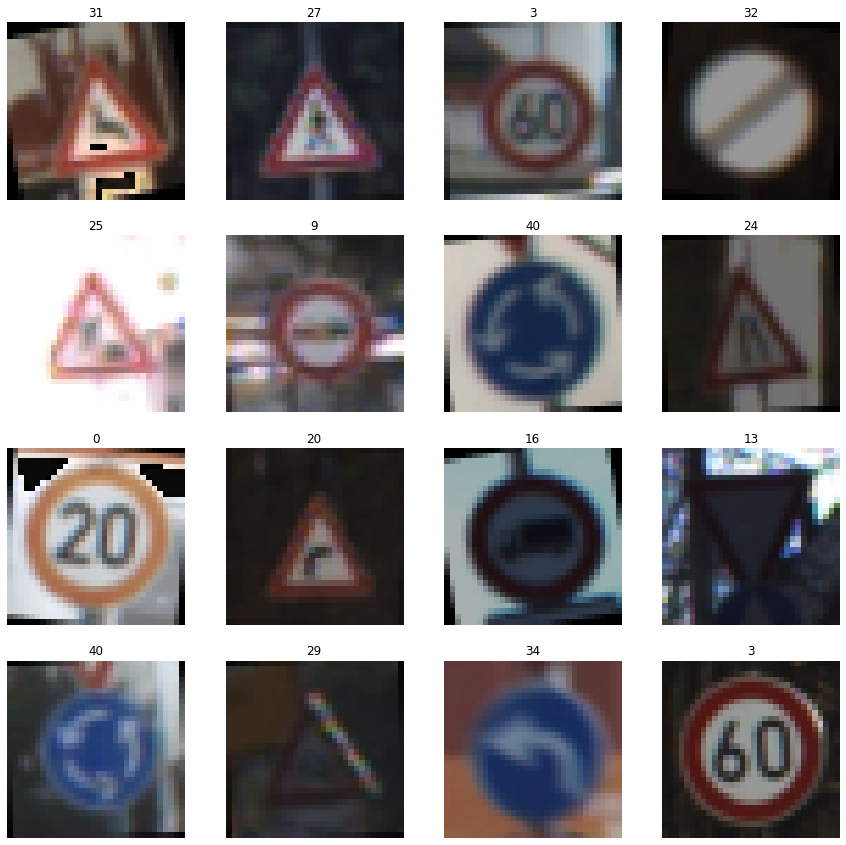

In [ ]:
plt.figure(figsize=(15, 15))
rows = 10


for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  j = np.random.choice(range(len(x_train_org)))
  plt.imshow(x_train_org[j].astype("uint8"))
  plt.title(int(y_train_org[j]))
  plt.axis("off")

## **Build the ResNet Model**

Model's architecutre is given in the below tables. By entering each stage (except the first stage), the number of filters is doubled and the spatial resolution is halved. You should use appropriate hyperparameters (kernel-size, no-filter, ...) to achieve at least 85% accuracy.

<center>
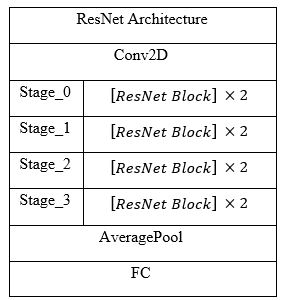
</center>
<h3><center> Model's architecture </center></h3>

<center>
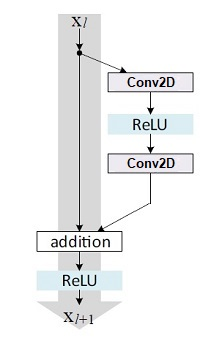
</center>

<h3><center> ResNet block architecture </center><h3>

In [ ]:
def resnet_layer(inputs,
                 num_filters=8,
                 kernel_size=3,
                 strides=1,
                 activation='relu'):

    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')

    x = inputs
    x = conv(x)
    if activation is not None:
        x = Activation(activation)(x)
    return x

In [ ]:
def resnet(input_shape, num_stage, num_res_blocks, num_classes):

    # Start model definition.
    num_filters = 8

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs, kernel_size=5)
    # Instantiate the stage of residual units
    for stage in range(num_stage):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stage
            if stage > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stage
            if stage > 0 and res_block == 0:  
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None)
            # print(stage)
            # print(x.shape)
            # print(y.shape)
            x = tf.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2


    x = AveragePooling2D(pool_size=4)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = resnet(input_shape, 4, 2, num_classes)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 8)    608         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 8)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 8)    584         ['activation[0][0]']             
                                                                                              

## **Plot the model**

Use the imported util to visualize the model.

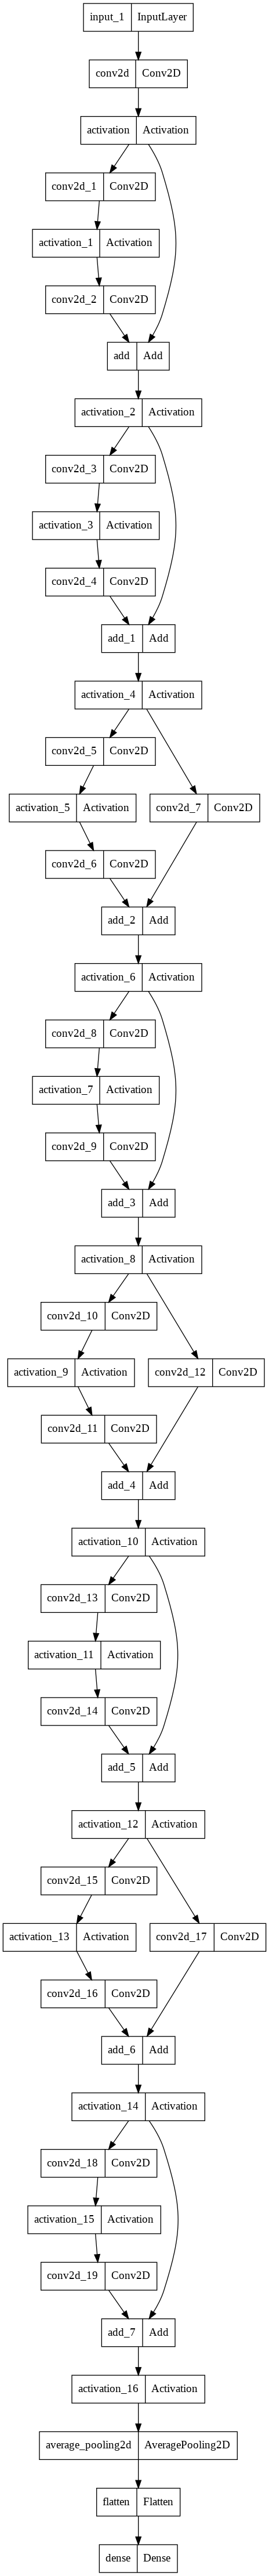

In [ ]:
plot_model(model, to_file='resnet.png')

## **Train the model**

Train the model on the second dataset (preprocessed)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 50
es_callback = EarlyStopping(monitor='val_acc', min_delta=0, patience=5)

In [ ]:
history= model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[es_callback])

Epoch 1/50
2719/2719 [==============================] - 78s 24ms/step - loss: 1.1157 - acc: 0.6664 - val_loss: 0.5295 - val_acc: 0.8372
Epoch 2/50
2719/2719 [==============================] - 61s 22ms/step - loss: 0.1882 - acc: 0.9427 - val_loss: 0.3857 - val_acc: 0.8916
Epoch 3/50
2719/2719 [==============================] - 71s 26ms/step - loss: 0.1188 - acc: 0.9636 - val_loss: 0.4055 - val_acc: 0.9041
Epoch 4/50
2719/2719 [==============================] - 91s 33ms/step - loss: 0.0948 - acc: 0.9718 - val_loss: 0.4743 - val_acc: 0.9009
Epoch 5/50
2719/2719 [==============================] - 78s 29ms/step - loss: 0.0854 - acc: 0.9747 - val_loss: 0.3830 - val_acc: 0.9145
Epoch 6/50
2719/2719 [==============================] - 68s 25ms/step - loss: 0.0734 - acc: 0.9780 - val_loss: 0.6607 - val_acc: 0.8832
Epoch 7/50
2719/2719 [==============================] - 65s 24ms/step - loss: 0.0682 - acc: 0.9800 - val_loss: 0.3596 - val_acc: 0.9218
Epoch 8/50
2719/2719 [==========================

## **Test the model**

In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

138/138 [==============================] - 2s 12ms/step - loss: 0.4348 - acc: 0.9345
Test loss: 0.43483734130859375
Test accuracy: 0.9344671368598938


### **Plot loss and accuracy**

In this part you should plot the loss and accuracy of train and test.

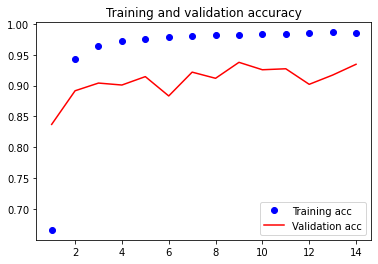

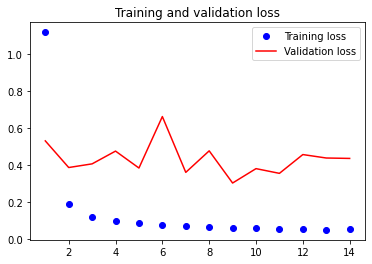

In [ ]:
def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

plot_history(history)